In [41]:
# This file is meant to verify the correctness of the implementation of the
# standardization of the data

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np


%matplotlib widget
# Load the data
base_dir = '/datasets/AddBiomechanics/processed_data/'

dataset = 'Falisse2017'
dataset = 'Wang2023'
dataset = 'vanderZee2022'
dataset = 'Tan2022'
dataset = 'Fregly2012'
dataset = 'Camargo2021'
dataset = 'Moore2015'
dataset = 'Hamner2013'

file_version = 'phase'
file_name = f'{base_dir}{dataset}_{file_version}.parquet'
data = pd.read_parquet(file_name)
data.columns

Index(['subject', 'task', 'frame_number', 'time_step', 'contact_r',
       'contact_l', 'grf_x_r', 'grf_y_r', 'grf_z_r', 'grf_x_l', 'grf_y_l',
       'grf_z_l', 'cop_x_r', 'cop_y_r', 'cop_z_r', 'cop_x_l', 'cop_y_l',
       'cop_z_l', 'pelvis_angle_s', 'pelvis_angle_f', 'pelvis_angle_t',
       'hip_angle_s_r', 'hip_angle_f_r', 'hip_angle_t_r', 'knee_angle_s_r',
       'ankle_angle_s_r', 'ankle_angle_t_r', 'hip_angle_s_l', 'hip_angle_f_l',
       'hip_angle_t_l', 'knee_angle_s_l', 'ankle_angle_s_l', 'ankle_angle_t_l',
       'dorsi_angle_r', 'dorsi_angle_l', 'shank_angle_r', 'shank_angle_l',
       'thigh_angle_r', 'thigh_angle_l', 'shank_vel_r', 'shank_vel_l',
       'thigh_vel_r', 'thigh_vel_l', 'ankle_vel_r', 'ankle_vel_l',
       'pelvis_vel_s', 'pelvis_vel_f', 'pelvis_vel_t', 'hip_vel_s_r',
       'hip_vel_f_r', 'hip_vel_t_r', 'knee_vel_s_r', 'ankle_vel_s_r',
       'ankle_vel_t_r', 'hip_vel_s_l', 'hip_vel_f_l', 'hip_vel_t_l',
       'knee_vel_s_l', 'ankle_vel_s_l', 'ankle_vel_t_l'

In [42]:
data['subject'].unique()

array(['subject17', 'subject20', 'subject01', 'subject08', 'subject04',
       'subject02'], dtype=object)

In [43]:
# Display all the tasks for 'subject5'
data['task'].unique()

array(['run200', 'run300', 'run400', 'run500'], dtype=object)

In [44]:
def convert_Hamner2013(df):
    # This dataset only contains running
    df['task_info'] = df['task']
    df['task'] = 'run'

    # Running speed is dependent on the integer value of the task
    # Tasks are 'run200', 'run300', 'run400', and 'run500'	
    for i in range(2,6):
        df.loc[df['task_info'].str.contains(str(i)), 'walking_speed'] = float(i)


def convert_Moore2015(df):
    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = df['task']

    # There's only level-ground walking in this dataset
    df['task'] = 'level_walking'

    # Add a list of the walking speeds
    # https://peerj.com/articles/918/ 
    # Table 1
    walking_speed_task_speed_list = [
        # [Task number, Speed (m/s)]
        # 0.8 m/s
        [[9,12,15,16,19,25,32,40,46,49,55,61,67,73,76],0.8],
        # 1.2 m/s
        [[10,13,17,20,26,31,41,47,50,56,62,68,74,77],1.2],
        # 1.6 m/s
        [[11,14,18,21,27,33,42,48,51,57,63,69,75,78],1.6],
    ]

    # Add a column called walking_speed
    df['walking_speed'] = None

    # Set the walking speed for each task
    for task_list,speed in walking_speed_task_speed_list:
        for task in task_list:
            # First, convert the task number to a string
            task_str = str(task)
            # Then, set the walking speed for the task
            df.loc[df['task_info'].str.contains(task_str), 'walking_speed'] = speed

    # Add the mass of the subjects so that we can mass normlize the torques
    subject_to_mass = {
        'subject1': 101.0,
        'subject11': 80.0,
        'subject4': 74.0,
        'subject7': 64.5,
        'suject8': 74.9,
        'subject9': 67.0,
        'subject5': 71.2,
        'subject6': 86.8,
        'subject3': 54.0,
        'subject12': 74.2,
        'subject13': 58.0,
        'subject10': 92,
        'subject15': 80.5,
        'subject17': 88.3, 
        'subject16': 75.0,
    }
    df['mass'] = df['subject'].map(subject_to_mass)

    # For every torque that we have in the dataset, we need to mass normalize it
    # to the subject's mass
    # find all the columns that have the word torque in them
    torque_columns = [col for col in df.columns if 'torque' in col]
    for col in torque_columns:
        df[col] = df[col] / df['mass']
            

def convert_Camargo2021(df):
    # Add a column called task_info with additional information 
    # about the task.
    df['task_info'] = df['task']

    # Create a list of the original tasks and the new task name
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['treadmill', 'level_walking'],
        ['Treadmill', 'level_walking'],
        ['levelground', 'level_walking'],
        ['LevelGround', 'level_walking'],

        ['ramp', 'ramp'],
        ['Ramp', 'ramp'],

        ['stairs', 'stairs'],
        ['Stairs', 'stairs'],
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task


def convert_Fregly2012(df):
    # Keep th original task column as task_info 
    df['task_info'] = df['task']
    # Set the subject name as the first two characters of the task
    df['subject'] = df['task'].str[:2]
    # Remove the first three characters of the task name
    df['task_info'] = df['task_info'].apply(lambda x: x[3:])

    # Create a list of the original tasks and the new task name
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['ngait', 'level_walking'],              # Normal Gait
        
        ['mtpgait', 'modified_walking'],    # Medial Trus
        ['medthrust', 'modified_walking'],  # Medial Thrust
        ['mtgait', 'modified_walking'],     # Medial Thrust Gait

        ['wpgait', 'modified_walking'],     # Walking Pole
        ['tsgait', 'modified_walking'],     # Trunk Sway Gait
        
        ['mildcrouch', 'modified_walking'], # Mild Crouch Gait
        ['crouch_og', 'modified_walking'],  # Crouch Gait
        
        ['bouncy', 'modified_walking'],     # Bouncy Gait
        ['smooth', 'modified_walking'],     # Smooth Gait?
        ['rightturn', 'modified_walking'],  # Right Turn
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task

def convert_Tan2022(df):
    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = None
    
    # This dataset only has running
    df['task'] = 'run'

def convert_vanderZee2022(df):
    # https://www.nature.com/articles/s41597-022-01817-1/tables/3
    # Has all the information for the speed, step length, step frequency, 
    # step width, and walking condition

    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = df['task']
    # Split the information from trial{number} to {number} (i.e. remove 
    # the word trial)
    df['task_info'] = df['task_info'].str.replace('trial', '')

    # Create a list of the original tasks and the new task name
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['trial', 'level_walking'],
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task


def convert_Wang2023(df):
    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = df['task']
    # Split the information in task info from {task}_{number} to {number}
    df['task_info'] = df['task_info'].str.split('_').str[-1]
    
    # Create a list of the original tasks and the new task name 
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['walk', 'level_walking'],
        ['run', 'run'],
        ['static_pose', 'static_pose'],
        ['jump', 'Jump'],
        ['lunge', 'Lunge'],
        ['squat', 'Squat'],
        ['land', 'Land'],
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task


def convert_Falisse2017(df):
    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = df['task']
    # Split the information in task info from {task}_{number} to {number}
    df['task_info'] = df['task_info'].str.split('_').str[1]

    # Create a list of the original tasks and the new task name
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['Gait', 'level_walking'],
        ['StairUp', 'up_stair'],
        ['StairDown', 'down_stair'],
        ['STS', 'sit-to-stand-to-sit'],
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task



#convert_Fregly2012(data)
#data['subject'].unique()

# convert_Moore2015(data)
# print(data['subject'].unique())
# print(data['task'].unique())
# print(data['walking_speed'].unique())
# print(data['task_info'].unique())

In [46]:
def plot_features(data, features, axis):
    for leg in ['r', 'l']:
        leg_df = data[data['phase_leading_leg'] == leg]
        x = np.linspace(0, 1, 150)
        fig, ax = plt.subplots(len(axis), len(features), squeeze=False, 
                            # Figsize depending on the number of features
                            figsize=(len(features)*5, len(axis)*5))

        for feat_i, feature in enumerate(features):
            for ax_i, axi in enumerate(axis):
                data_name = feature + '_' + axi + '_' + leg
                # Average out the data
                d = leg_df[data_name].values.reshape(-1,150)
                d_avg = np.mean(d,axis=0)
                d_std = np.std(d,axis=0)
                ax[ax_i, feat_i].plot(x,d_avg, label=data_name)
                ax[ax_i, feat_i].fill_between(x, d_avg - d_std, d_avg + d_std, alpha=0.3)
                ax[ax_i, feat_i].set_title(data_name)
        plt.suptitle("Leg " + leg)
        plt.tight_layout()

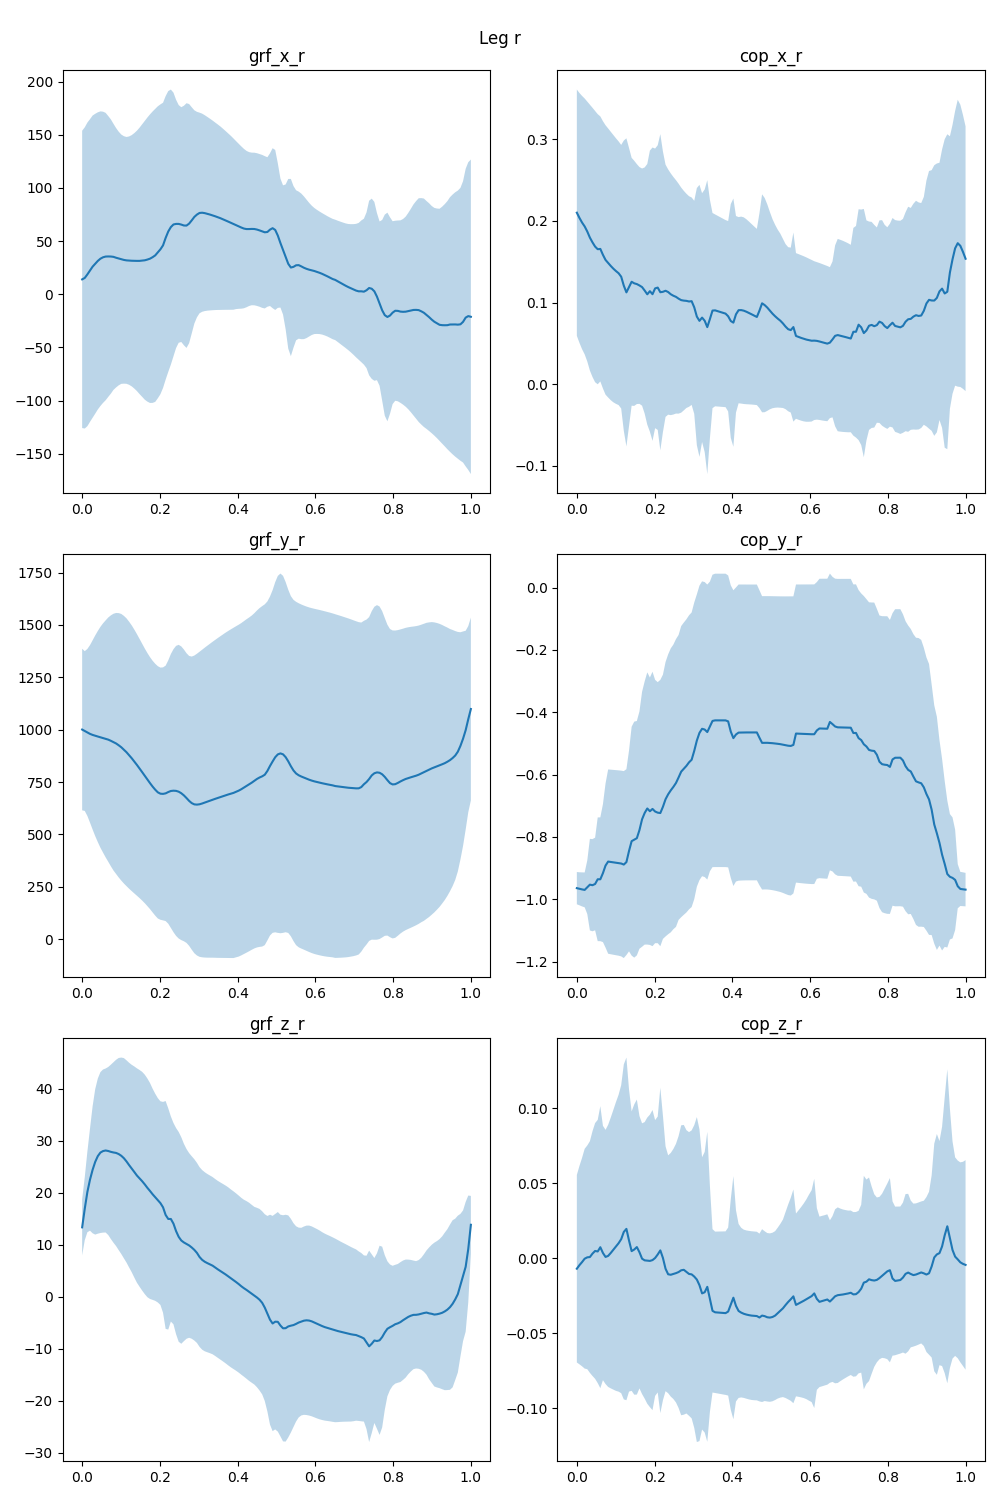

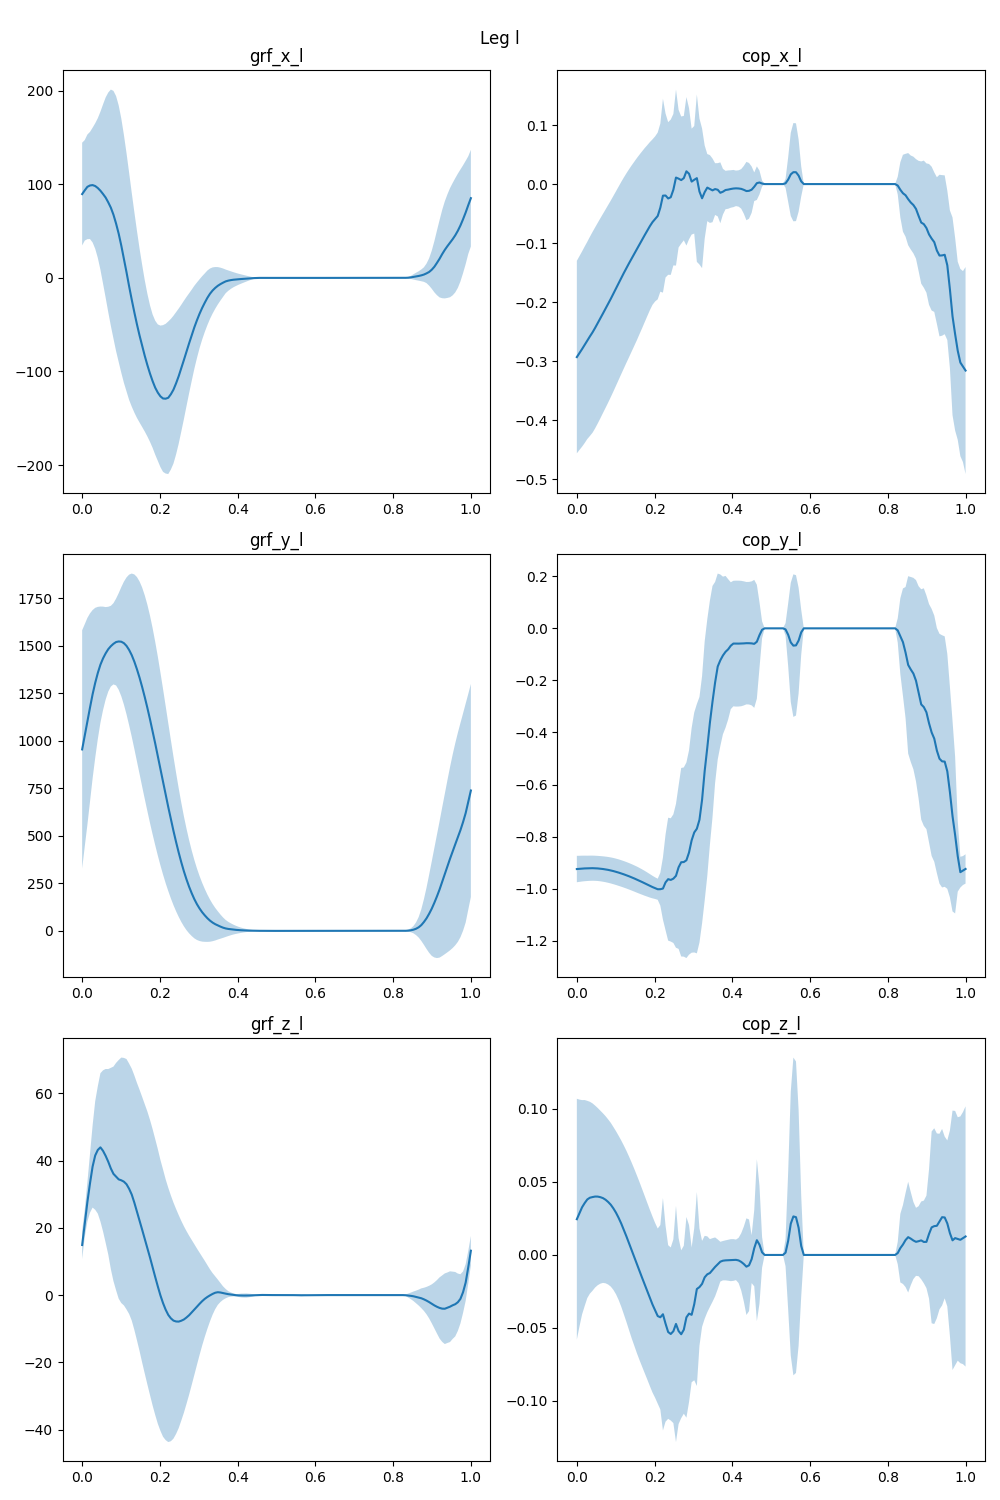

In [47]:
features = ['grf', 'cop']
axis = ['x', 'y', 'z']
plot_features(data, features, axis)

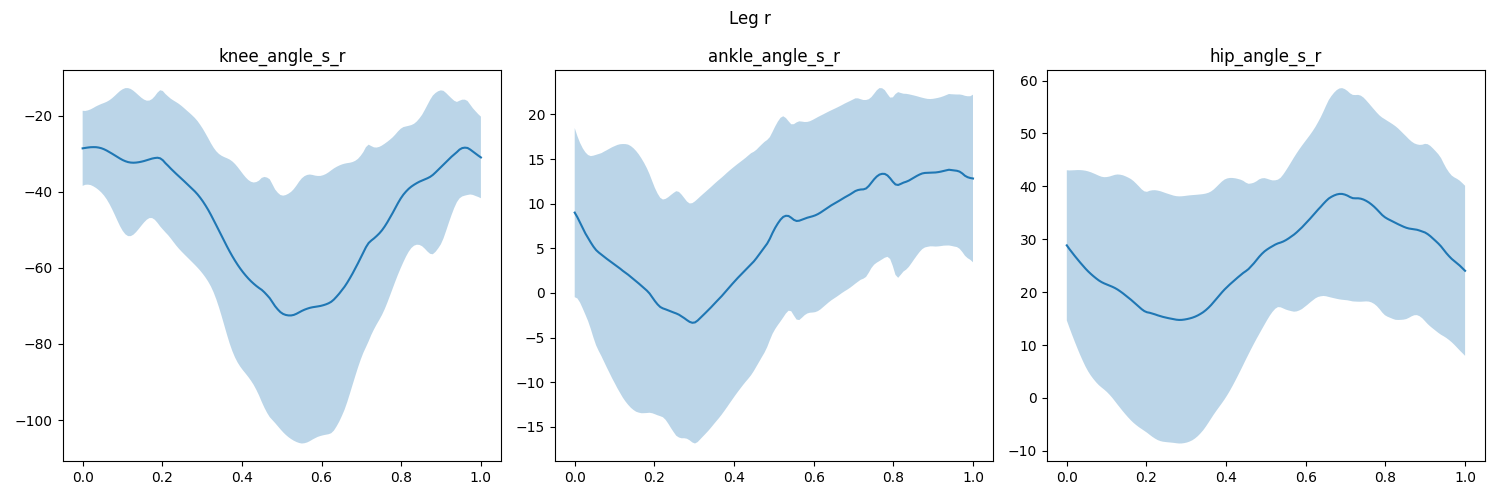

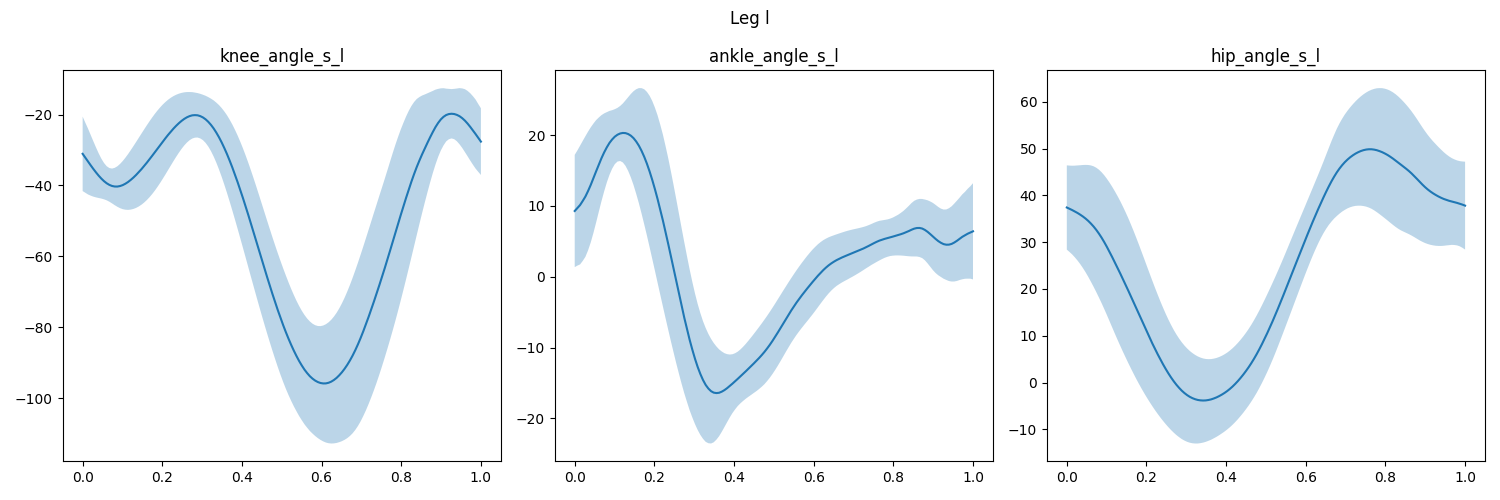

In [48]:
features = ['knee_angle', 'ankle_angle', 'hip_angle']
axis = ['s']
plot_features(data, features, axis)


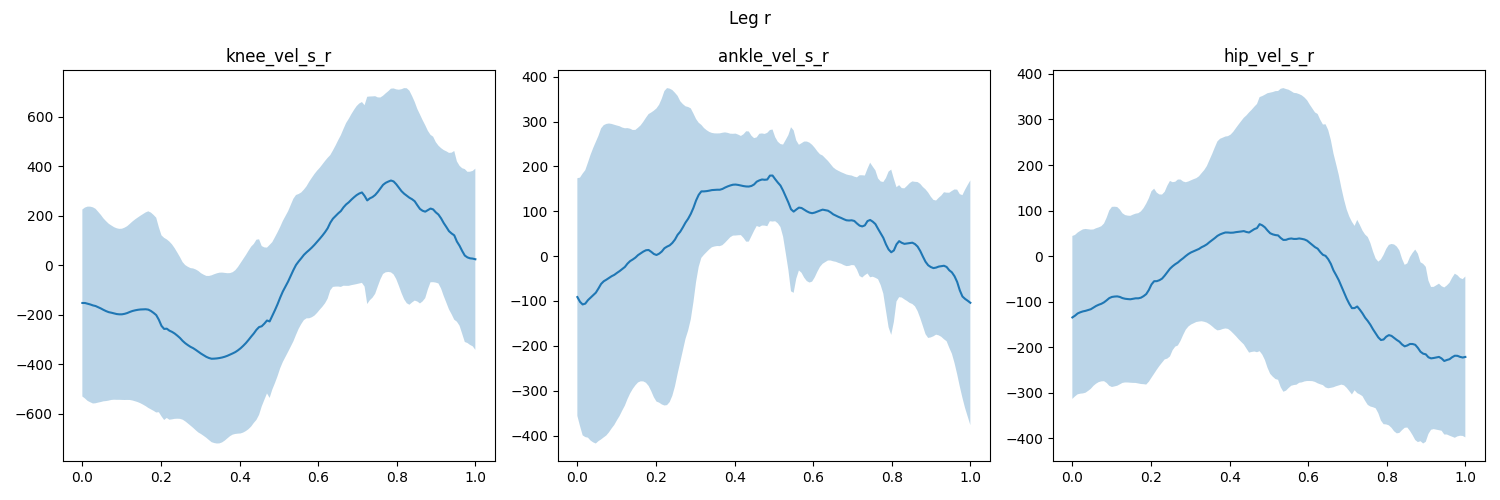

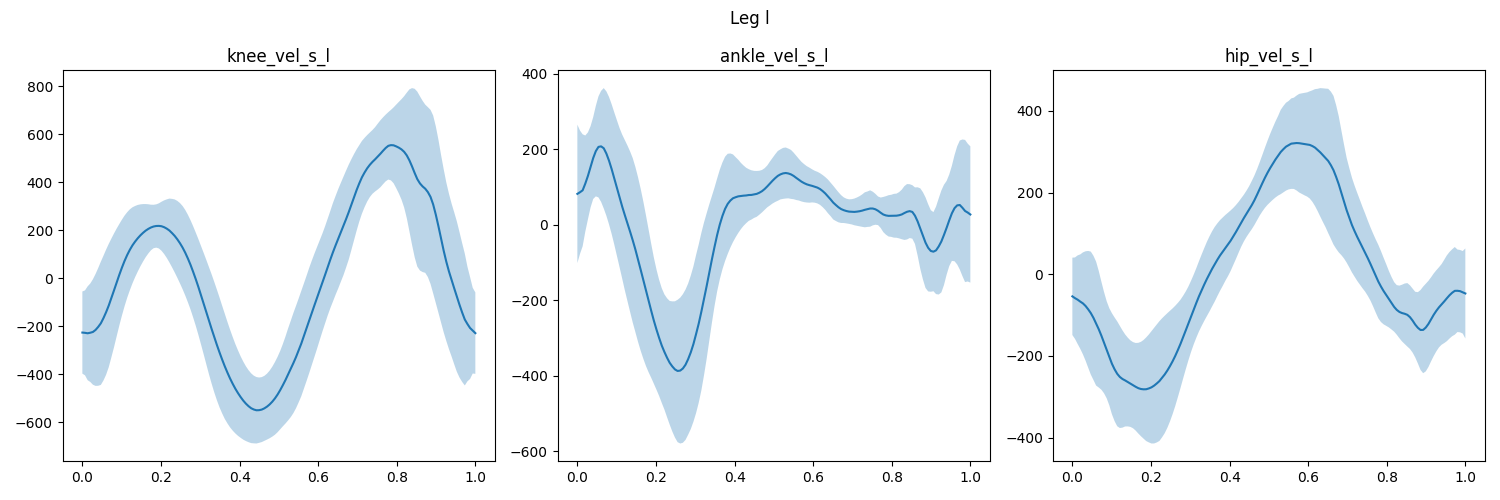

In [49]:
features = ['knee_vel', 'ankle_vel', 'hip_vel']
axis = ['s']
plot_features(data, features, axis)

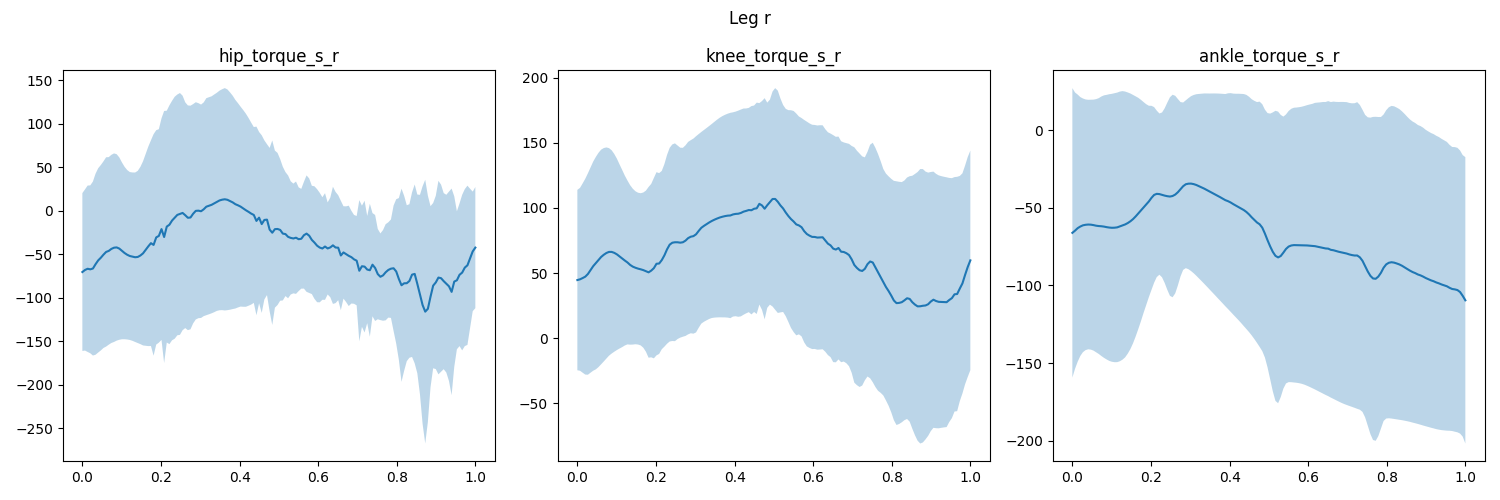

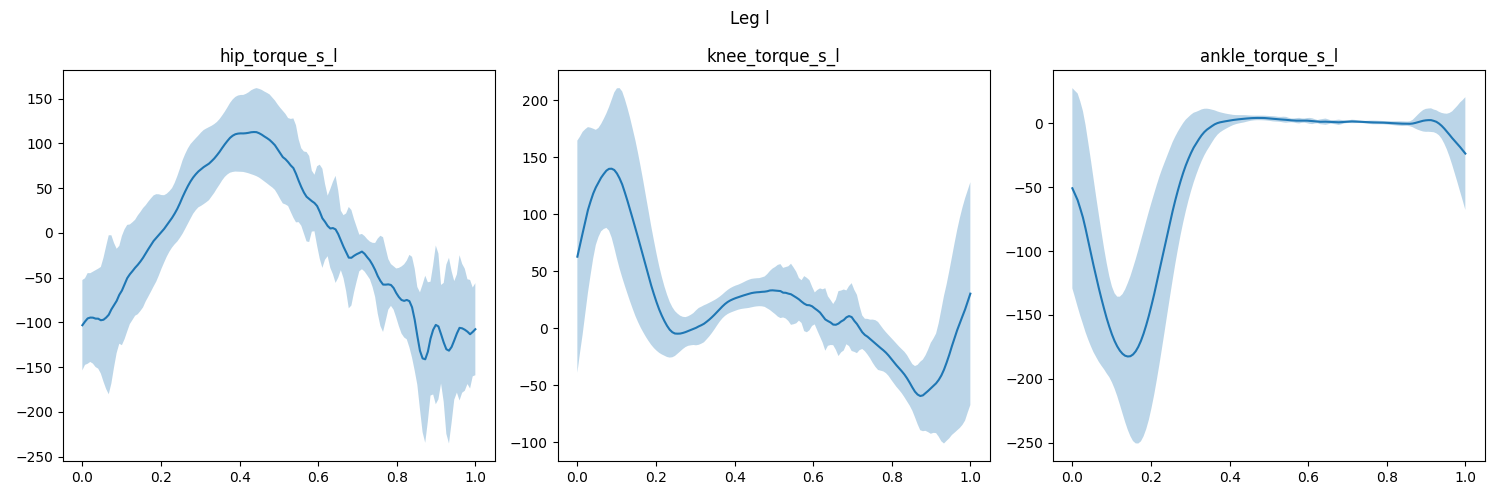

In [50]:
features = ['hip_torque', 'knee_torque', 'ankle_torque']
axis = ['s']
plot_features(data, features, axis)